In [1]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

###
# SciKitLearn Imports
###
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

###
# MatPlotLib Settings
###

plt.rcParams["figure.figsize"] = (20,9)
sb.set()


################################
# Initialisers
################################

# Load the Data files
fitsarr = np.load("fitslist.npy")
fluxarr = np.load("fluxlist.npy")
#planetarr = np.load("planetlist.npy")
isplanetarr = np.load("isplanetlist.npy")

In [2]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

Text(0, 0.5, 'PDCSAP Flux (e-/s)')

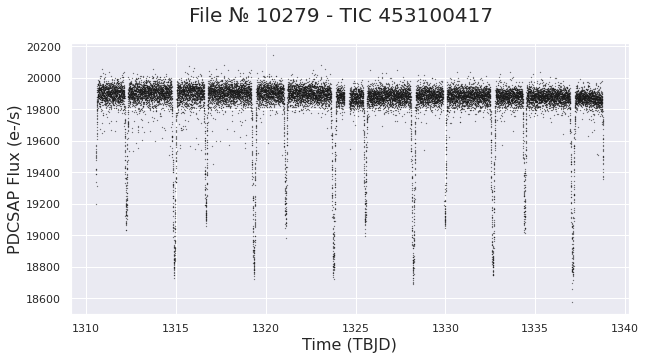

In [134]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)
plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots()

ax.plot(x,y, 'k.', markersize=0.5)

fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

In [28]:
NPL = np.load("planetlist.npy")

In [45]:
NPL[:50]

array([ 2372579,  2669197,  2669197,  6353299,  6353299,  6400274,
        6471862,  6471862,  6471862,  6477929,  6477929,  6594108,
        6594108,  6594108,  6594108,  6670946,  6670946,  6670946,
        6670946,  6671953,  6671953,  6671953,  6720642,  6720642,
        6720642,  6949210,  7018206,  7084116,  7084116,  7088246,
        7127224,  7127224, 24672008, 24695017, 24695017, 25064731,
       25064731, 25078924, 25078924, 25080867, 25081091, 25133286,
       25134377, 25134377, 25134377, 25134567, 25134567, 25134567,
       25134567, 25153007])

In [48]:
def FINDPLANET(inputStr):
    for i in range(len(fitsarr)):
        k = str(fitsarr[i])

        if inputStr in k:
            return i

In [65]:
PLIST = []

for i in NPL:
    PLIST.append(FINDPLANET(str(i)))
PLIST = set(PLIST)
PLIST = list(PLIST)
PLIST.sort()

In [108]:
len(PLIST)

3146

In [131]:
goodlist = [3, 13, 17, 82, 84, 102, 120, 124, 130, 133,
            139, 140, 145, 174, 177, 190, 213, 230, 234, 235,
            245, 250, 253, 257, 274, 282, 285, 286, 297, 313,
            318, 346, 352, 369, 374, 378, 379, 391, 396]

bestlist = [0, 124, 190, 235, 245, 282, 285, 286, 346, 352, 369, 378, 379]

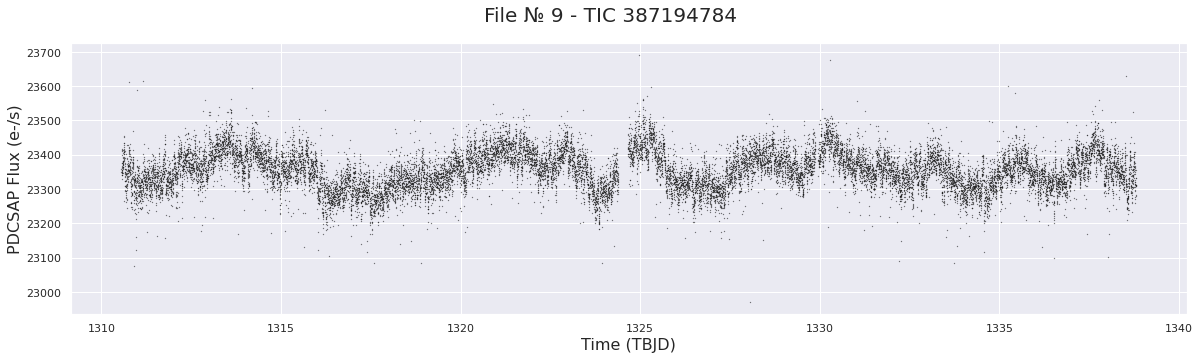

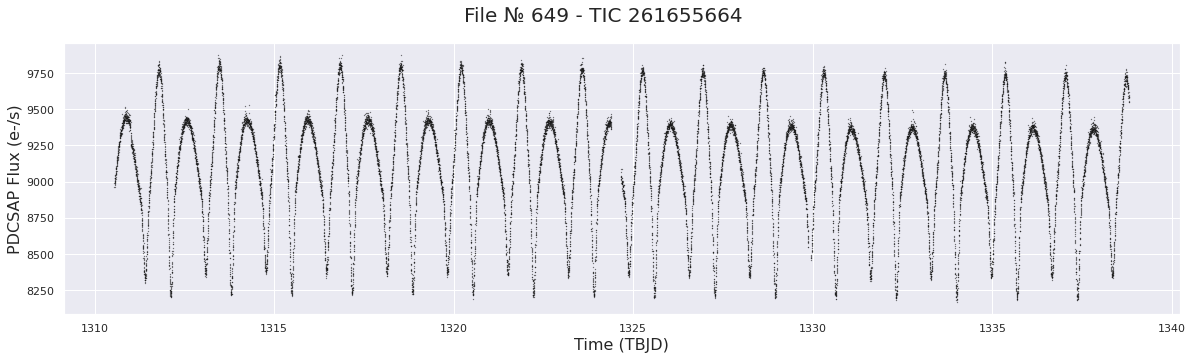

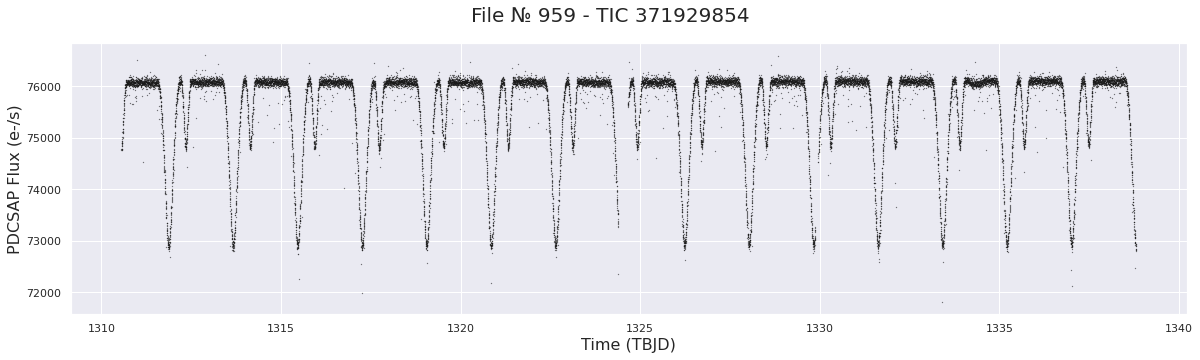

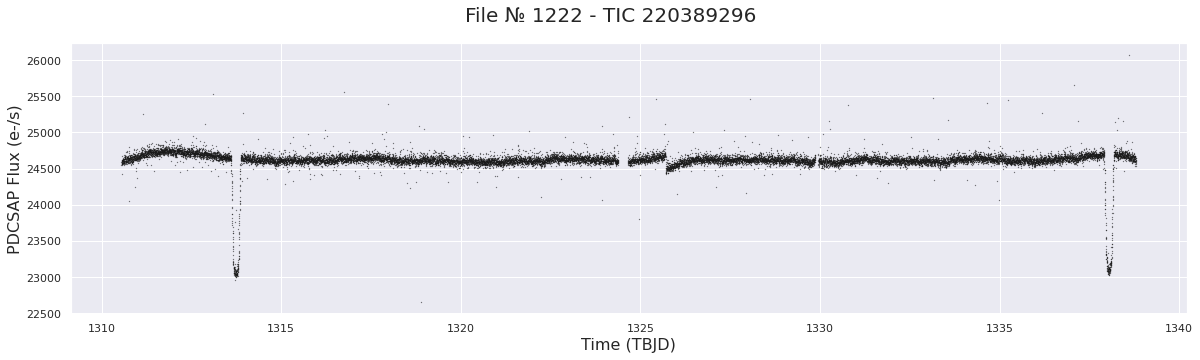

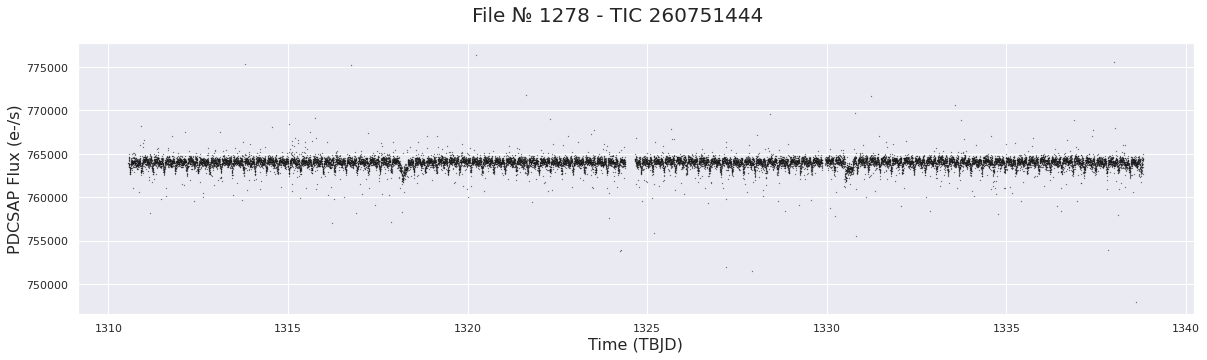

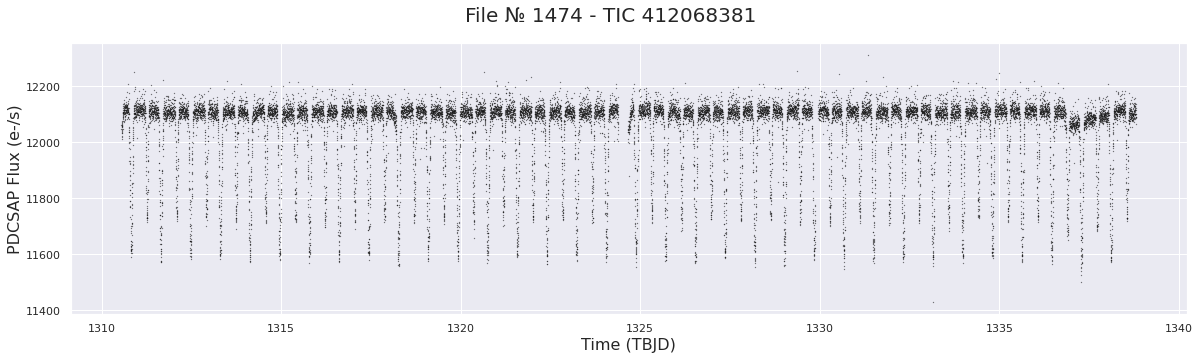

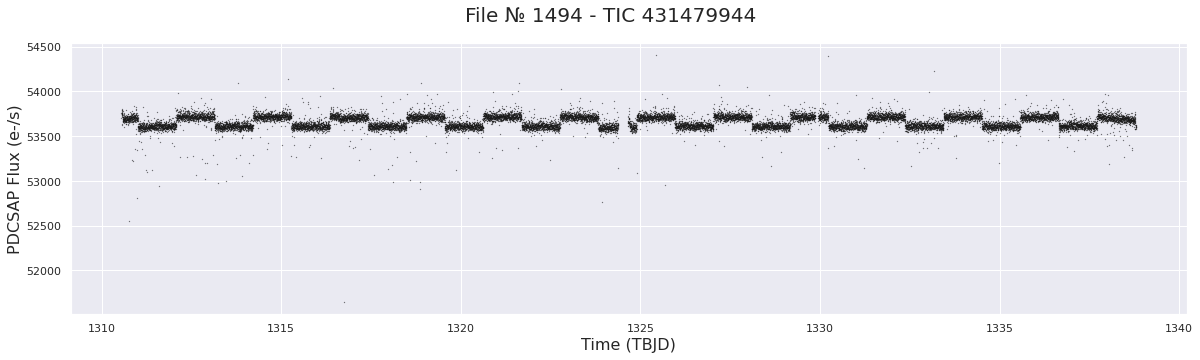

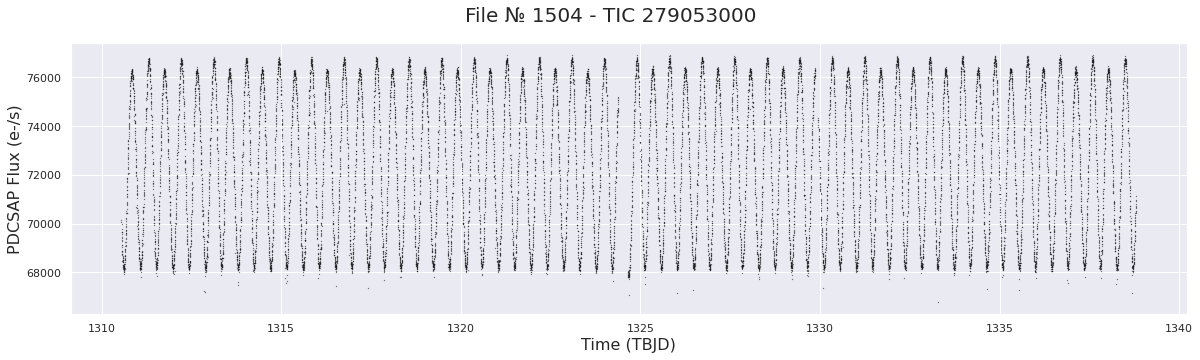

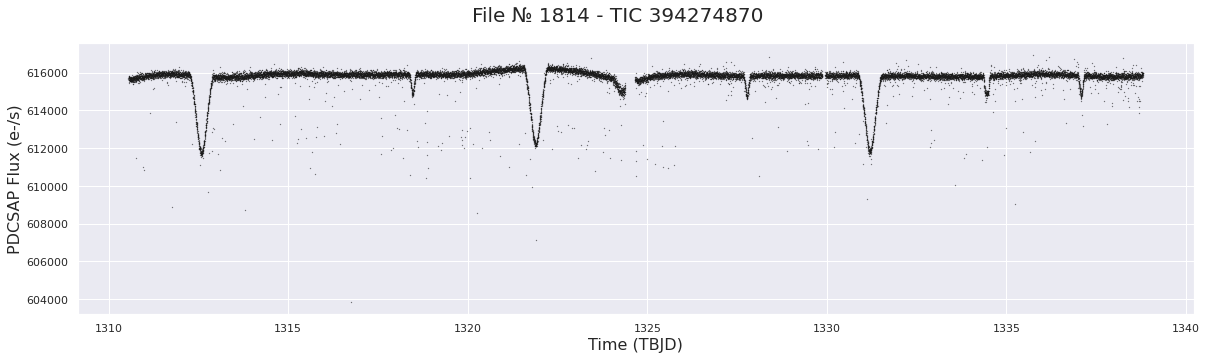

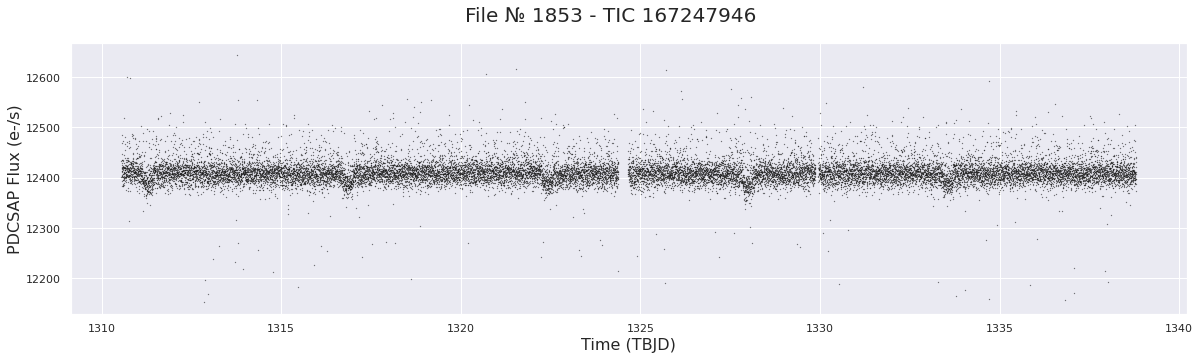

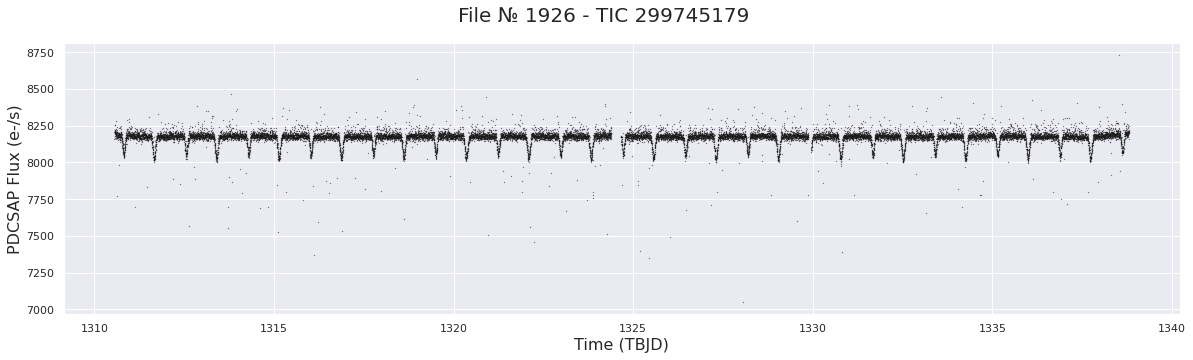

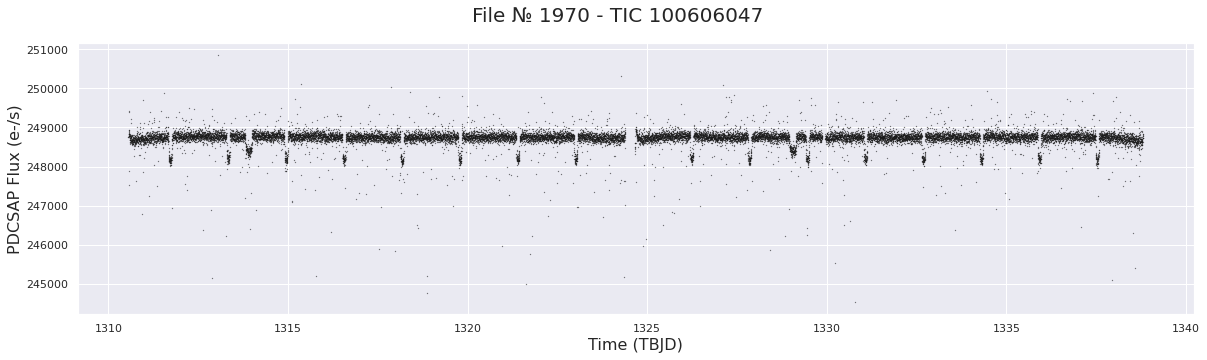

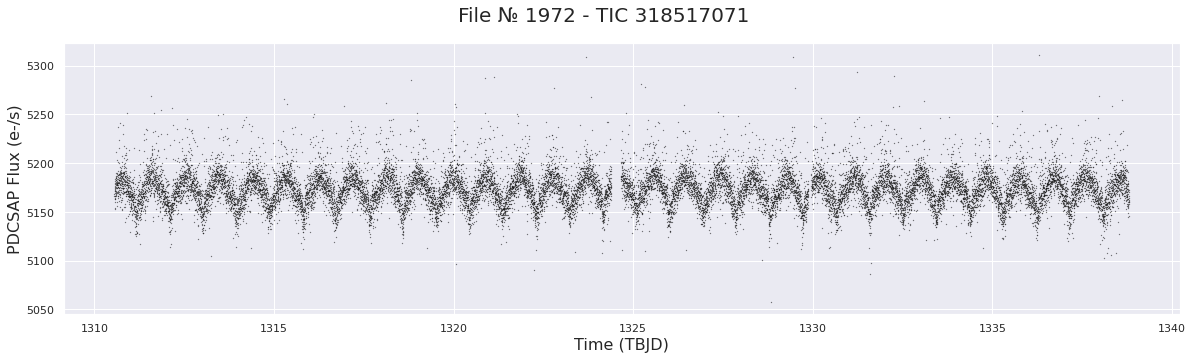

In [132]:
plt.rcParams["figure.figsize"] = (20,5)

for n,i in enumerate(bestlist):
    x,y,f,o,s,ylab,xlab = DrawLC(PLIST[i])

    fig, ax = plt.subplots()

    ax.plot(x,y, 'k.', markersize=0.5)

    fig.suptitle(f"File № {f} - {o}", fontsize=20) # + str(obj) + " - Sector " + str(sector))

    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'Relative Flux')

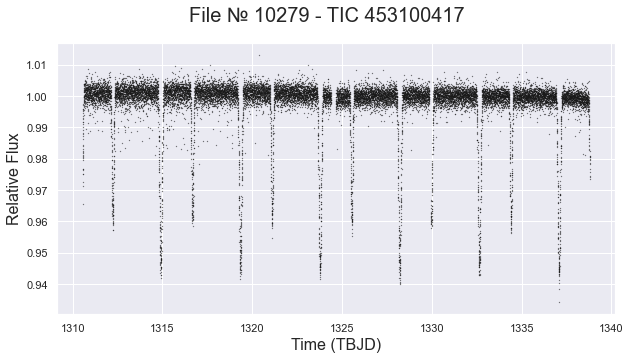

In [11]:
y_ave = np.median(y)
y_norm = y/y_ave

fig, ax = plt.subplots()

ax.plot(x,y_norm, 'k.', markersize=0.5)

fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel("Relative Flux", fontsize=16)

(18500.0, 20200.0)

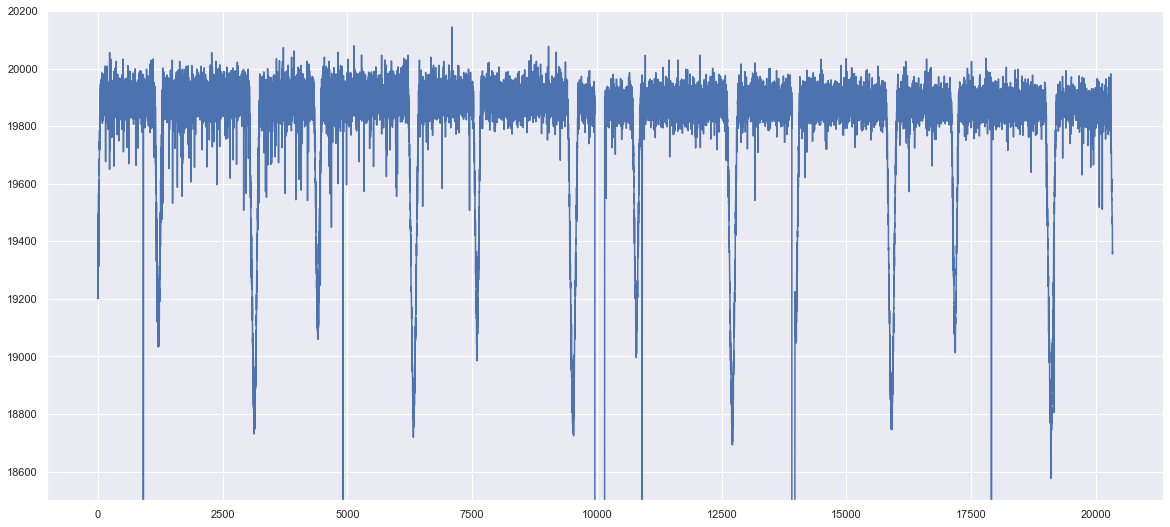

In [4]:
plt.plot(y)
plt.ylim(18500,20200)

(18500.0, 20200.0)

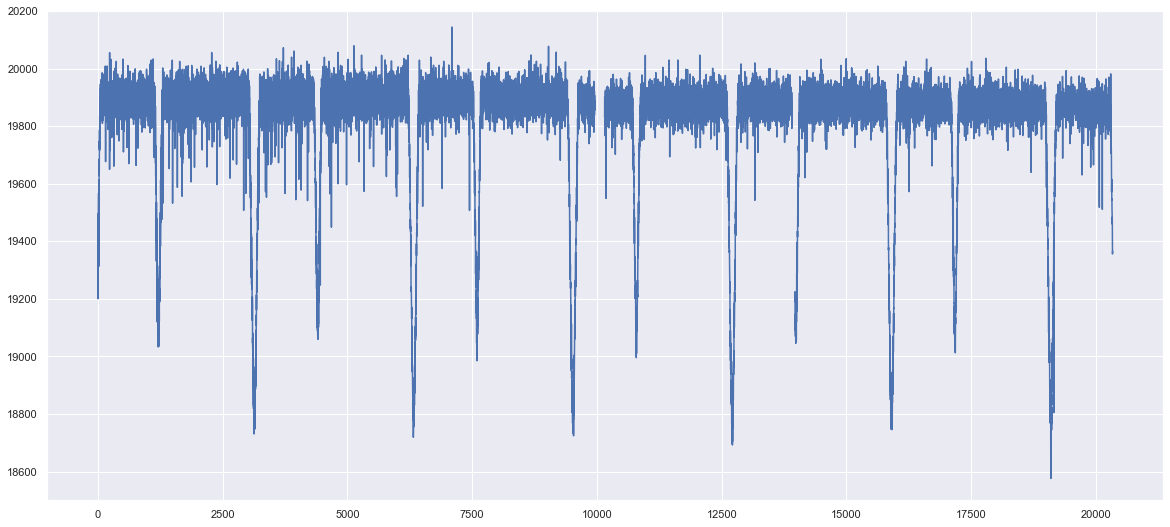

In [5]:
Y = y.copy()
Y[Y==0]=np.nan
plt.plot(Y)
plt.ylim(18500,20200)

## It seems like the zeroes are CONSISTENTLY in the SAME PLACES
### I will investigate this further by checking the Zeroes in two completely different LCs

In [6]:
x1,y1,f1,o1,s1,_,_ = DrawLC(10279)
ynew = [idx for idx, element in enumerate(y1) if element == 0]
ynew[0:10]

[908, 4908, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966]

In [7]:
x2,y2,f2,o2,s2,_,_ = DrawLC()
outputy2 = [idx for idx, element in enumerate(y2) if element == 0]
outputy2[0:10]

[908, 4908, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966]

In [8]:
y1[9955:9965]

array([19886.406, 19888.402, 19857.096, 19866.664,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ], dtype=float32)

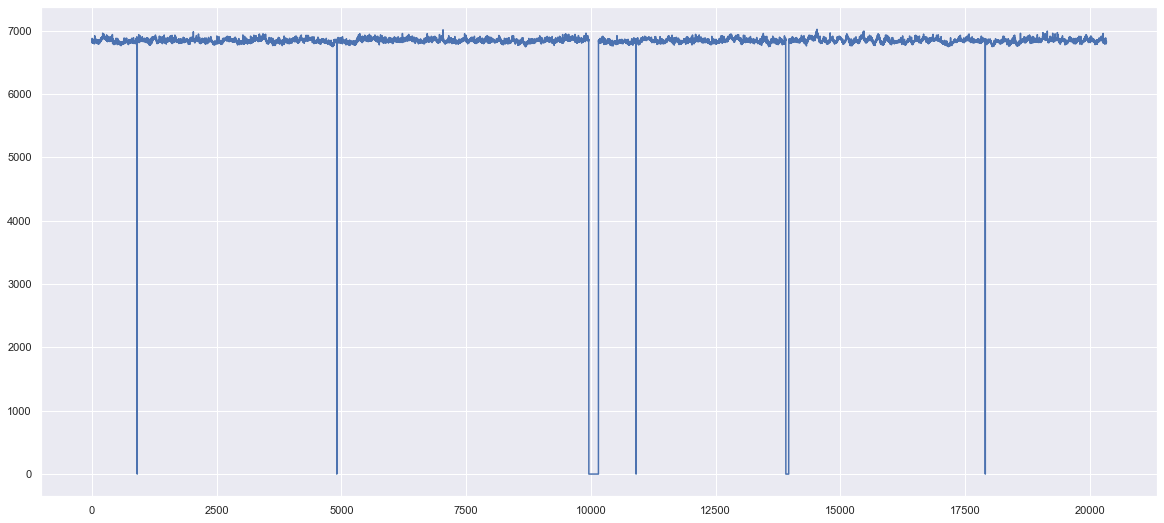

In [9]:
plt.plot(y2)

In [11]:
ynew==outputy2

True

In [12]:
x1,y1,_,_,_,_,_ = DrawLC()
outputy1 = [idx for idx, element in enumerate(y1) if element == 0]
x2,y2,_,_,_,_,_ = DrawLC()
outputy2 = [idx for idx, element in enumerate(y2) if element == 0]

outputy1==outputy2

True

In [13]:
XDIF=np.diff(x)
XDIFRND=np.around(XDIF,8)
XDIFRND[:40]

array([0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886,
       0.00138886, 0.00138886, 0.00138886, 0.00138886, 0.00138886])

In [14]:
max(XDIFRND)

0.00138887

In [15]:
min(XDIFRND)

0.00138886

In [17]:
unique, counts = np.unique(XDIFRND, return_counts=True)
dict(zip(unique, counts))

{0.00138886: 5839,
 0.00138887: 14233,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1,
 nan: 1

In [18]:
np.nanmean(np.diff(x))

0.0013888657082140865

In [19]:
delta_d = np.nanmean(np.diff(x))

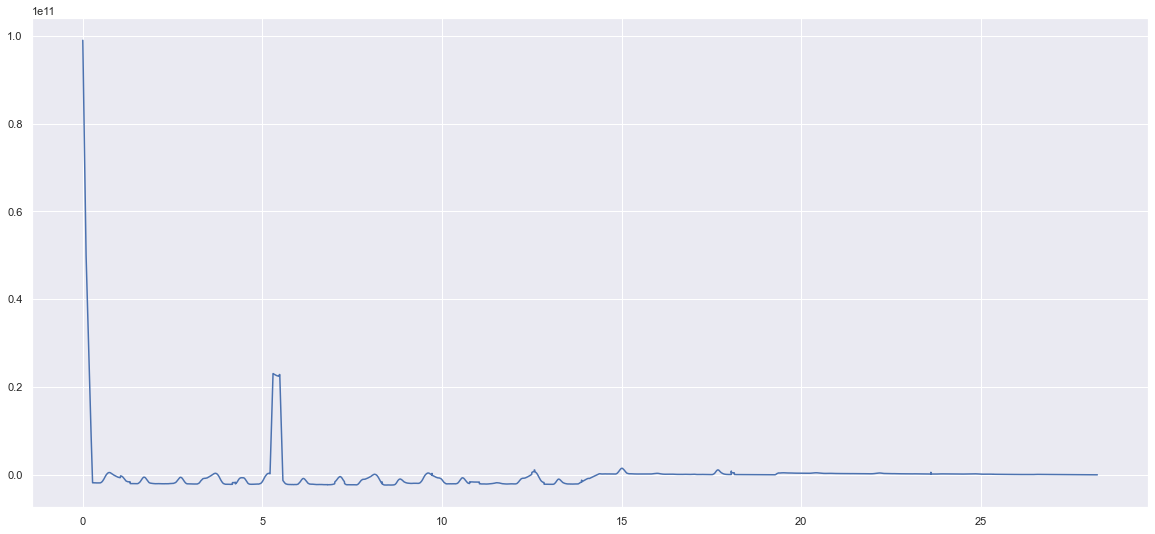

In [20]:
TMP = np.correlate(y-np.mean(y),y-np.mean(y),mode='full')

plt.plot(np.arange(len(y)-1)*delta_d,TMP[len(y):])

plt.tick_params(axis='x', which='minor', bottom=True)